Inductive Source Simulation: Conductive Sphere
========================================

## Geoscientific Problem

for this code comparison, we simulated the transient response from a conductive sphere in a vacuum. The sphere had a conductivity of $\sigma$ = 100 S/m. The center of the sphere was located at (0,0,-50) and had a radius of $a$ = 8 m.

The transient response was simulated for x, y and z oriented magnetic dipoles at (-5, 0, 10). The x, y and z components of H and dB/dt were simulated at (5, 0, 10). However, we only plot the data for horizontal coaxial, horizontal coplanar and vertical coplanar geometries.

*A figure illustrating the conductivity model and survey geometry is shown further down*

## Codes/Formulations Being Compared

**Analytic Formulation:** Wait and Spies analytic solution. See https://em.geosci.xyz/content/maxwell3_fdem/inductive_sources/sphere/index.html for a summary of the solution. Reference: J. R. Wait. A conductive sphere in a time varying magnetic field. Geophysics, 16:666–672, 1951.

**SimPEG 3D OcTree Formulation:**

**UBC TD Octree v1:** [TD OcTree v1](https://tdoctree.readthedocs.io/en/tdoctree_v1/) is a voxel cell TDEM forward modeling and inversion package developed by the UBC Geophysical Inversion Facility. This software is proprietary and can ONLY be acquired through appropriate [academic](https://gif.eos.ubc.ca/software/licenses_academic) or [commerical](https://gif.eos.ubc.ca/software/licenses_commercial) licenses. The numerical approach of the forward simulation is described in the [online manual's theory section](https://tdoctree.readthedocs.io/en/tdoctree_v1/content/theory.html). If you have a valid license, there are instructions for reproducing the results (add link).

**UBC TD Octree v2:** [TD OcTree v2](https://tdoctree.readthedocs.io/en/tdoctree_v2/) is a voxel cell TDEM forward modeling and inversion package developed by the UBC Geophysical Inversion Facility. This software is proprietary and can ONLY be acquired through appropriate [academic](https://gif.eos.ubc.ca/software/licenses_academic) or [commerical](https://gif.eos.ubc.ca/software/licenses_commercial) licenses. The numerical approach of the forward simulation is described in the [online manual's theory section](https://tdoctree.readthedocs.io/en/tdoctree_v2/content/theory.html). If you have a valid license, there are instructions for reproducing the results (add link).

## Loading Assets Into the SimPEG Framework

We start by importing any necessary packages for running the notebook.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from discretize import TreeMesh
from SimPEG import maps
mpl.rcParams.update({'font.size':14})

mu0 = 4*np.pi*1e-7
times = np.logspace(-5, -2, 10)

plot_analytic = True
plot_simpeg_octree = True
plot_ubc_tdoctree_v1 = False
plot_ubc_tdrh_v2 = True

Next we download the mesh, model and simulated data for each code.

In [2]:
# For each package, download .tar files

The mesh, model and predicted data for each code are then loaded into the SimPEG framework for plotting.

In [3]:
rootdir = './../../../assets/tdem/sphere_vacuum_conductive_fwd'
mesh_simpeg = TreeMesh.read_UBC(rootdir+'_simpeg/octree_mesh.txt')
model_simpeg = TreeMesh.read_model_UBC(mesh_simpeg, rootdir+'_simpeg/model.con')

data_list = []
legend_str = []
style_list = ['k-o', 'b-o', 'r-o', 'g-o', 'c-o']

if plot_analytic:
    fname = '_simpeg/dpred_analytic.txt'
    data_array = np.loadtxt(rootdir+fname, skiprows=1)[:, 1:]
    data_array = np.reshape(data_array, (3, len(times), 6))
    data_list.append(data_array)
    legend_str.append('Analytic')

if plot_simpeg_octree:
    fname = '_simpeg/dpred_octree.txt'
    data_array = np.loadtxt(rootdir+fname, skiprows=1)[:, 1:]
    data_array = np.reshape(data_array, (3, len(times), 6))
    data_list.append(data_array)
    legend_str.append('SimPEG OcTree')

if plot_ubc_tdoctree_v1:
    fname = '_ubc_octree/fwd_v1/dpred0.txt'
    temp = np.loadtxt(rootdir+fname)[:, 7:]
    temp = np.c_[times, temp]
    data_list.append(temp)
    legend_str.append('TD OcTree v1')

if plot_ubc_tdrh_v2:
    fname1 = '_ubc_octree/fwd_tdrh_v2_h/dpredFwd.txt'
    fname2 = '_ubc_octree/fwd_tdrh_v2_dbdt/dpredFwd.txt'
    temp = np.r_[
        np.loadtxt(rootdir+fname1)[:, -1], np.loadtxt(rootdir+fname2)[:, -1]
    ]
    temp = np.reshape(temp, (3*len(times), 6), order='F')
    temp = np.reshape(temp, (3, len(times), 6))
    data_list.append(temp)
    legend_str.append('TDRH v2')

## Plot Geophysical Scenario

Below, we plot the conductivity model and survey geometry for the forward simulation.

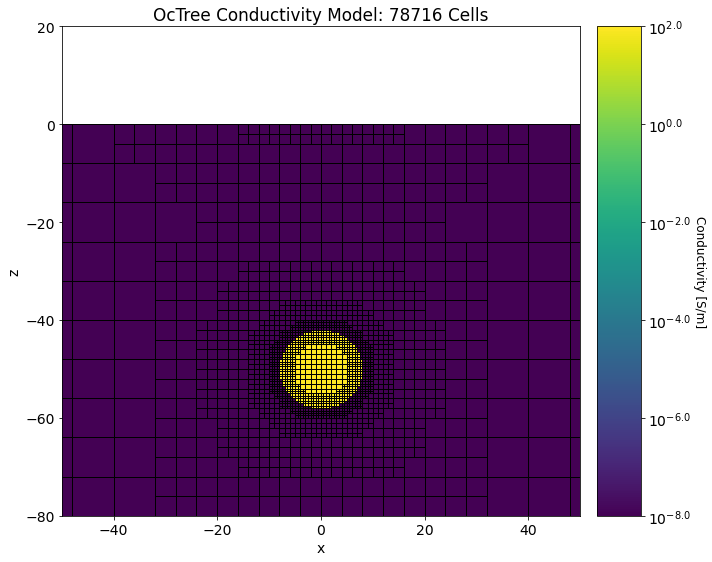

In [4]:
fig = plt.figure(figsize=(12,8))
ind_active = mesh_simpeg.cell_centers[:, 2] < 0
plotting_map = maps.InjectActiveCells(mesh_simpeg, ind_active, np.nan)
log_model = np.log10(model_simpeg[ind_active])

ax1 = fig.add_axes([0.14, 0.1, 0.6, 0.85])
mesh_simpeg.plot_slice(
    plotting_map * log_model,
    normal="Y", ax=ax1, ind=int(mesh_simpeg.h[1].size / 2), clim=(np.min(log_model), np.max(log_model)),
    grid=True
)

ax1.set_xlim([-50, 50])
ax1.set_ylim([-80, 20])
ax1.set_title("OcTree Conductivity Model: {} Cells".format(mesh_simpeg.nC))

ax2 = fig.add_axes([0.76, 0.1, 0.05, 0.85])
norm = mpl.colors.Normalize(
    vmin=np.min(log_model), vmax=np.max(log_model)
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", format="$10^{%.1f}$"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)

## Plotting Simulated Data

Here we plot the simulated data for all codes. We plot the only the data for horizontal coaxial, horizontal coplanar and vertical coplanar geometries.

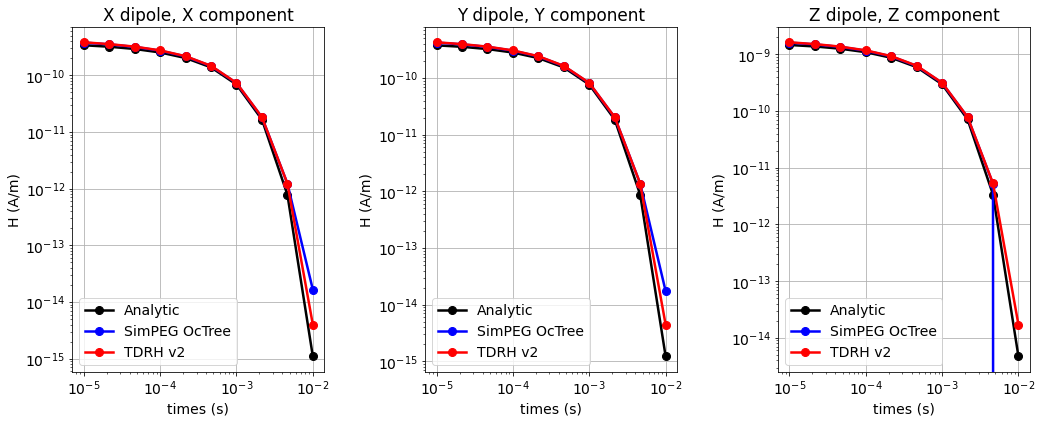

In [5]:
fig = plt.figure(figsize=(14, 6))
lw = 2.5
ms = 8

ax1 = 3*[None]

for ii, comp in enumerate(['X','Y','Z']):
    
    ax1[ii] = fig.add_axes([0.05+0.35*ii, 0.1, 0.25, 0.8])
    
    for jj in range(0, len(data_list)):
        ax1[ii].loglog(times, data_list[jj][ii, :, ii], style_list[jj], lw=lw, markersize=ms)
        
    ax1[ii].grid()
    ax1[ii].set_xlabel('times (s)')
    ax1[ii].set_ylabel('H (A/m)')
    ax1[ii].set_title(comp + ' dipole, ' + comp + ' component')
    ax1[ii].legend(legend_str,loc="lower left")

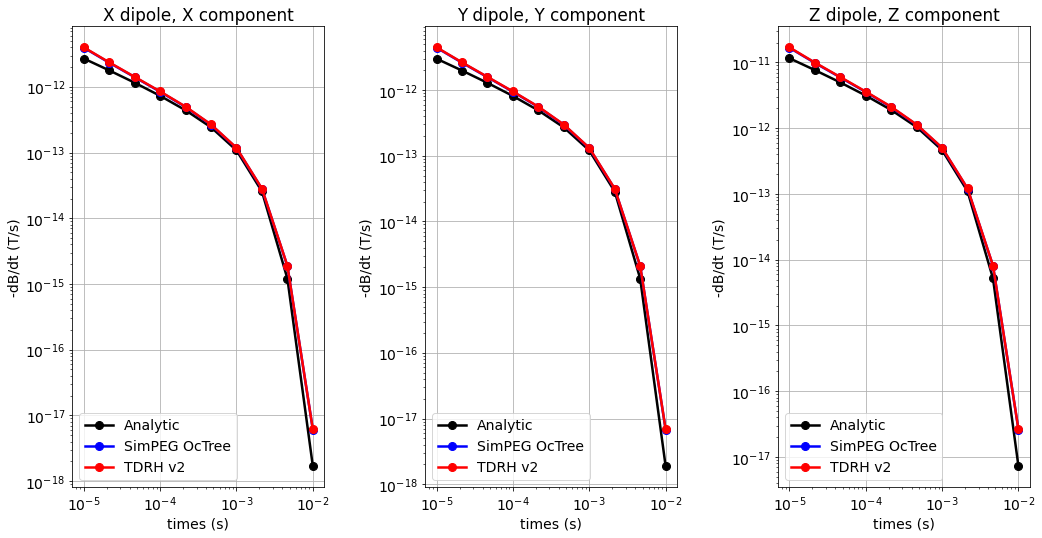

In [6]:
fig = plt.figure(figsize=(14, 8))
lw = 2.5
ms = 8

ax1 = 3*[None]

for ii, comp in enumerate(['X','Y','Z']):
    
    ax1[ii] = fig.add_axes([0.05+0.35*ii, 0.1, 0.25, 0.8])
    
    for jj in range(0, len(data_list)):
        ax1[ii].loglog(times, -data_list[jj][ii, :, ii+3], style_list[jj], lw=lw, markersize=ms)
        
    ax1[ii].grid()
    ax1[ii].set_xlabel('times (s)')
    ax1[ii].set_ylabel('-dB/dt (T/s)')
    ax1[ii].set_title(comp + ' dipole, ' + comp + ' component')
    ax1[ii].legend(legend_str,loc="lower left")